<a href="https://colab.research.google.com/github/colinjhorgan/MLTSA22_CHorgan/blob/main/HW8/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
import numpy as np
import pandas as pd
import pylab as plt
%pylab inline

from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Read in data

In [214]:
#Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [215]:
cd gdrive/MyDrive/kaggle/HW7/data

[Errno 2] No such file or directory: 'gdrive/MyDrive/kaggle/HW7/data'
/content/gdrive/MyDrive/kaggle/HW7/data


In [216]:
#Read in data from training set
lcvs = pd.read_csv('training_set.csv')
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


# Generate observations on identical timescales for all objects/filters

Here we standardize the time scales so all timeseries start at 0.

In [217]:
#Subtract min MJD from every time series so that all series start at 0
mjd_adj = lcvs.groupby(['object_id','passband'])['mjd'].apply(lambda x: x-x.min())
lcvs['mjd_adj'] = mjd_adj.values

lcvs

,object_id,mjd,passband,flux,flux_err,detected,mjd_adj
0,615,59750.4229,2,-544.810303,3.622952,1,0.0000
1,615,59750.4306,1,-816.434326,5.553370,1,0.0000
2,615,59750.4383,3,-471.385529,3.801213,1,0.0000
3,615,59750.4450,4,-388.984985,11.395031,1,0.0000
4,615,59752.4070,2,-681.858887,4.041204,1,1.9841
...,...,...,...,...,...,...,...
1421700,130779836,60555.9838,4,-39.881969,46.477093,0,833.6750
1421701,130779836,60560.0459,1,14.894439,18.947685,0,806.8968
1421702,130779836,60571.0225,5,30.593130,50.695290,0,855.6906
1421703,130779836,60585.9974,4,-23.471439,44.819859,0,863.6886


We do a quick check to see the smallest number of observations in a time series. Interpolation requires a minimum number of points to be performed, depending on the method, so if we have any time series with very few points we will have to attend to them specifically. If not, then we are lucky and can ignore this detail.

In [218]:
#Check to see the minimum number of observations per time series.
obs_count = lcvs.groupby(['object_id','passband'])[['mjd_adj']].count()
print(f'The fewest observations for a time series is {obs_count.reset_index().min()}')

The fewest observations for a time series is object_id    615
passband       0
mjd_adj        2
dtype: int64


# Linear Interpolation

Here we interpolate data at 100 evenly spaced intervals from the first to last observation of each object using linear interpolation.

In [219]:
#Test linear interpolation performance
lcvs_grouped = lcvs.groupby(['object_id','passband'])
lin_int = lcvs_grouped.apply(lambda x: interp1d(x.mjd_adj, x.flux, kind='linear')(np.linspace(0, int(x.mjd_adj.max()), 100)))
lin_data = pd.DataFrame(lin_int).reset_index().rename(columns={'0':'mjd_int'})

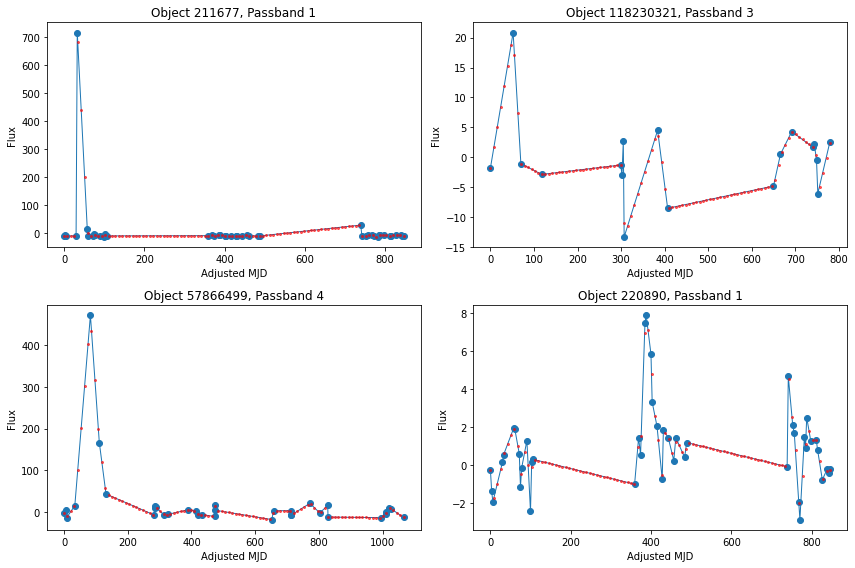

In [220]:
#Plot raw vs. interpolated data for 4 random objects using filter 3 (randomly chosen)
np.random.seed(10)
ids = lcvs.object_id.unique()[np.random.randint(0, lcvs.object_id.unique().shape[0], 4)]
filter = np.random.randint(0,5,4) #Check 4 random filters

fig, axs = plt.subplots(2,2,figsize=(12,8))
axs = axs.flatten()

for k in range(0,4):
  raw = lcvs.loc[(lcvs.object_id==ids[k]) & (lcvs.passband==filter[k])][['mjd_adj','flux']]
  interp = lin_data.loc[(lin_data.object_id==ids[k]) & (lin_data.passband==filter[k])]

  axs[k].plot(raw.mjd_adj, raw.flux, lw=1, marker='o')
  axs[k].plot(np.linspace(0, raw.mjd_adj.max(), 100), interp[0].values[0], ls=' ', color='red',
              marker='o', ms=2, alpha=.6)
  axs[k].set_title(f'Object {ids[k]}, Passband {filter[k]}')
  axs[k].set_xlabel('Adjusted MJD')
  axs[k].set_ylabel('Flux')

fig.tight_layout()

**Figure 1:** Results of Linear Interpolation at 100 evenly spaced intervals from the first to last observation of an object. Blue dots indicate raw observations, blue line shows connections between (for clarity). Red dots indicate interpolated data.


We can see in the above figure (and when you play around with the seed) that linear interpolation actually does a really good job in capturing the trends of the raw data. It tends to underperform where there are large gaps in time between observations. We find that linear interpolation creates a slope which may not be ideal. We will see how other methods perform.

For now, we want to visualize in aggregate how far off our linear interpolation is from our raw data in both mean and standard deviation. To do this we will visualize their difference.


In [221]:
#Take means, std of raw data and interpolated data and sum the differences
lin_df = pd.DataFrame(np.reshape(np.concatenate(lin_data[0]), (lin_data[0].shape[0], 100)))
lin_df = lin_df.merge(lin_data[['object_id','passband']], left_index=True, right_index=True).set_index(['object_id','passband'])

raw_grouped = lcvs.groupby(['object_id','passband']).agg({'flux':['mean','std']})
raw_grouped.columns = ['mean','std']

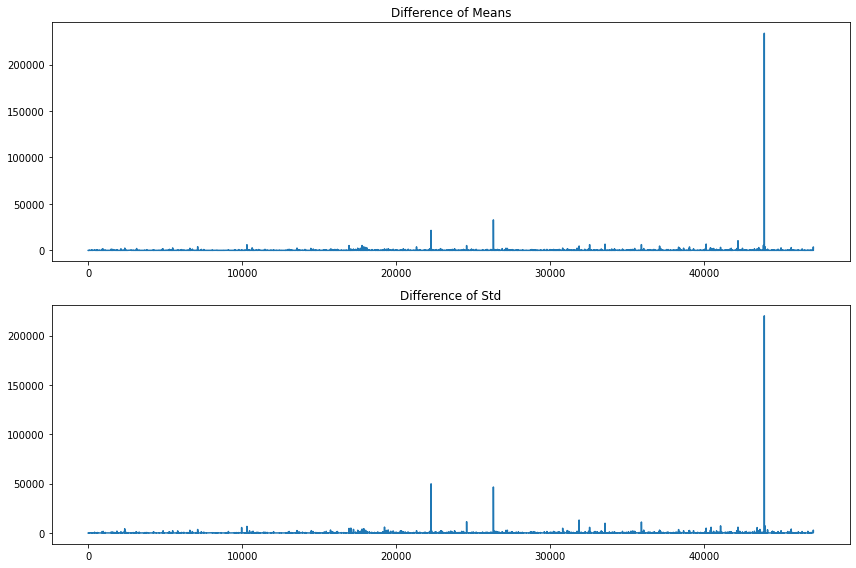

In [222]:
#Visualize Difference of Means and Standard Deviation between
fig, axs = plt.subplots(2, 1, figsize=(12,8))
axs = axs.flatten()

axs[0].plot(abs(raw_grouped['mean'].values - lin_df.mean(axis=1).values))
axs[0].set_title('Difference of Means')

axs[1].plot(abs(raw_grouped['std'].values - lin_df.std(axis=1).values))
axs[1].set_title('Difference of Std')

fig.tight_layout()

**Figure 2:** Difference of Mean and Standard Deviation between our raw data and our linearly interpolated data. Y values indicate the absolute value of the difference between the raw - interpolated mean(top) and std(bottom). The x axis represents each unique object_id/passfilter combination as they occur in sequence in our data.

This is not the cleanest way of visualizing this data. If I had enough time I would do something like a heatmap where the x axis is the raw series, the y axis is the interpolated series and the heatmap is colored according to the difference in quantities or perhaps correlation. Because of time constraints I cannot produce this figure.. but it would be really cool! 

The main takeaway of Figure 2 is that For the most part our averages and standard deviations remain close between raw and interpolated data with the exception of 3 large outliers.

# Quadratic Interpolation

Here we repeat the procedure for linear interpolation, but using a quadratic method. Because a quadratic spline requires 3 datapoints to interpolate, we linearly interpolate any object/filter series that have less than or equal to 3 data points

In [223]:
#Get object_ids/passbands of series with <= 3 observations
exclude_ = obs_count[obs_count.mjd_adj <= 3].reset_index()
exc_id = exclude_.object_id.astype('string') + '-' + exclude_.passband.astype('string')

#Create unique object_id/passfilter ids to exclude data
comp_id = lcvs.object_id.astype('string') + '-' + lcvs.passband.astype('string')

In [224]:
#Linearly interpolate data with fewer than 3 observations
lin_set = lcvs.loc[comp_id.isin(exc_id)]
lin_grouped = lin_set.groupby(['object_id','passband'])
lin_df = pd.DataFrame(lin_grouped.apply(lambda x: interp1d(x.mjd_adj, x.flux, kind='linear')(np.linspace(0, int(x.mjd_adj.max()), 100)))).reset_index()

In [225]:
#Quadratic interpolate all other data
quad_set = lcvs.loc[~comp_id.isin(exc_id)]
quad_grouped = quad_set.groupby(['object_id','passband'])
quad_df = pd.DataFrame(quad_grouped.apply(lambda x: interp1d(x.mjd_adj, x.flux, kind='quadratic')(np.linspace(0, int(x.mjd_adj.max()), 100)))).reset_index()

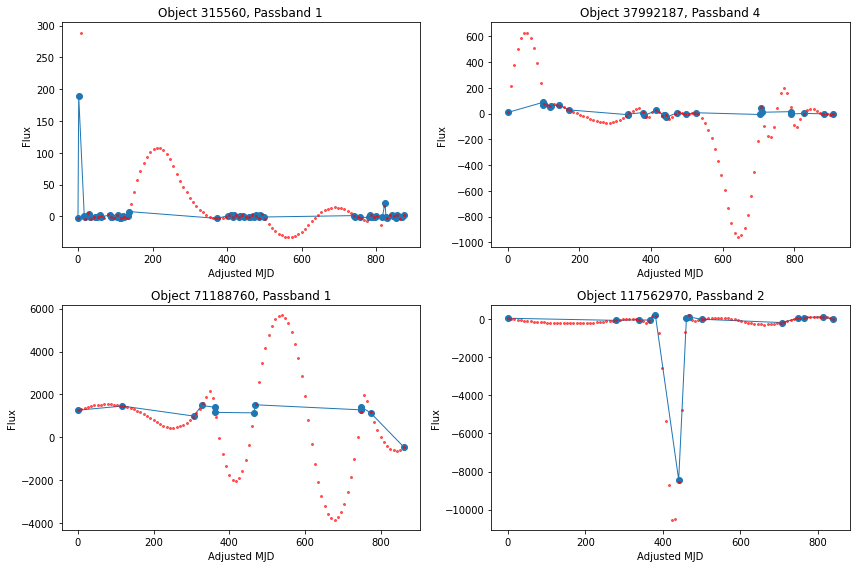

In [226]:
#Plot raw vs. interpolated data for 4 random objects using filter 3 (randomly chosen)
np.random.seed(11)
ids = quad_df.object_id.unique()[np.random.randint(0, quad_df.object_id.unique().shape[0], 4)]
filter = np.random.randint(0,5,4) #Check 4 random filters

fig, axs = plt.subplots(2,2,figsize=(12,8))
axs = axs.flatten()

for k in range(0,4):
  raw = lcvs.loc[(lcvs.object_id==ids[k]) & (lcvs.passband==filter[k])][['mjd_adj','flux']]
  interp = quad_df.loc[(quad_df.object_id==ids[k]) & (quad_df.passband==filter[k])]

  axs[k].plot(raw.mjd_adj, raw.flux, lw=1, marker='o')
  axs[k].plot(np.linspace(0, raw.mjd_adj.max(), 100), interp[0].values[0], ls=' ', color='red',
              marker='o', ms=2, alpha=.6)
  axs[k].set_title(f'Object {ids[k]}, Passband {filter[k]}')
  axs[k].set_xlabel('Adjusted MJD')
  axs[k].set_ylabel('Flux')

fig.tight_layout()

**Figure 3:** Results of Quadratic Interpolation at 100 evenly spaced intervals from the first to last observation of an object. Blue dots indicate raw observations, blue line shows connections between. Red dots indicates interpolated data.

As is fairly obvious from the above figure, quadratic interpolation does a pretty poor job of interpolation. This is likely because it overfits sudden increases in the raw data and then the prediction wildly overshoots to smooth the approximated curve. These results almost guarantee for me that cubic interpolation is going to be as bad, if not worse... but we will check it just to be sure.

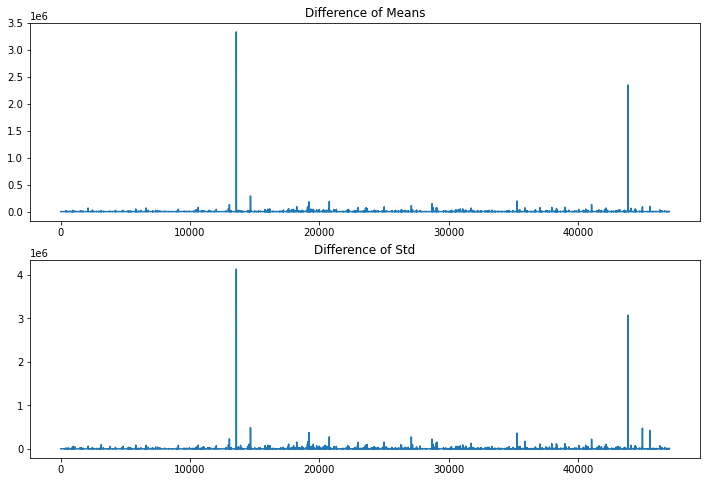

In [227]:
#Take means, std of raw data and interpolated data and sum the differences
quad_df = pd.DataFrame(np.reshape(np.concatenate(quad_df[0]), (quad_df[0].shape[0], 100)))

#Create unique index for raw grouped
raw_grouped = raw_grouped.reset_index()
raw_id = raw_grouped.object_id.astype('string') + '-' + raw_grouped.passband.astype('string')

#Visualize Difference of Means and Standard Deviation between
fig, axs = plt.subplots(2, 1, figsize=(12,8))
axs = axs.flatten()

axs[0].plot(abs(raw_grouped.loc[~raw_id.isin(exc_id)]['mean'].values - quad_df.mean(axis=1).values))
axs[0].set_title('Difference of Means')

axs[1].plot(abs(raw_grouped.loc[~raw_id.isin(exc_id)]['std'].values - quad_df.std(axis=1).values))
axs[1].set_title('Difference of Std');


**Figure 4:** Difference of Mean and Standard Deviation between our raw data and our quadratically interpolated data. Y values indicate the absolute value of the difference between the raw - interpolated mean(top) and std(bottom). The x axis represents each unique object_id/passfilter combination as they occur in sequence in our data.

Using quadratic interpolation, our errors have grown substantially, especially in two obvious instances.

# Cubic Interpolation

Here we repeat the procedure for linear interpolation, but using a cubic method. Because a cubic spline requires 4 datapoints to interpolate, we linearly interpolate any object/filter series that have less than or equal to 4 data points

In [228]:
#Get object_ids/passbands of series with <= 4 observations
exclude_ = obs_count[obs_count.mjd_adj <= 4].reset_index()
exc_id = exclude_.object_id.astype('string') + '-' + exclude_.passband.astype('string')

In [229]:
#Linearly interpolate data with fewer than 3 observations
lin_set = lcvs.loc[comp_id.isin(exc_id)]
lin_grouped = lin_set.groupby(['object_id','passband'])
lin_df = pd.DataFrame(lin_grouped.apply(lambda x: interp1d(x.mjd_adj, x.flux, kind='linear')(np.linspace(0, int(x.mjd_adj.max()), 100)))).reset_index()

In [230]:
#Cubic interpolation of all other data
cub_set = lcvs.loc[~comp_id.isin(exc_id)]
cub_grouped = cub_set.groupby(['object_id','passband'])
cub_df = pd.DataFrame(quad_grouped.apply(lambda x: interp1d(x.mjd_adj, x.flux, kind='cubic')(np.linspace(0, int(x.mjd_adj.max()), 100)))).reset_index()

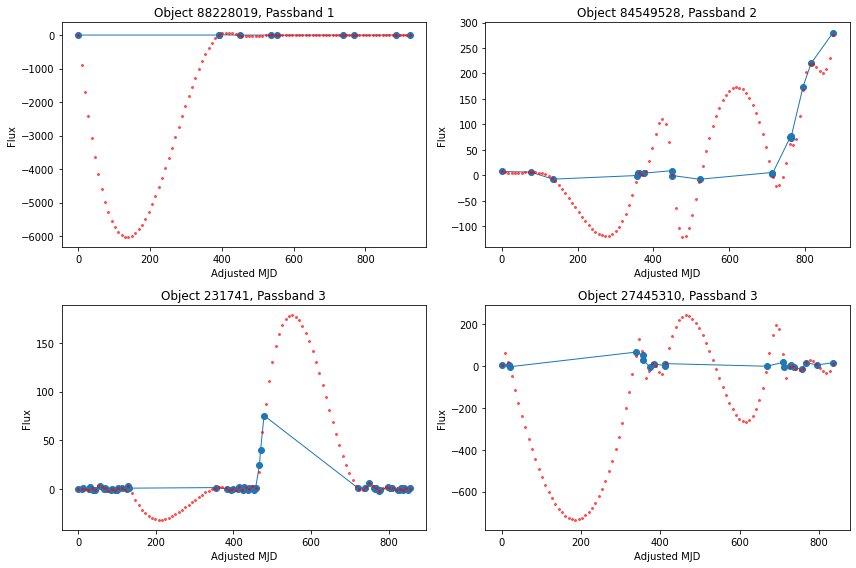

In [231]:
#Plot raw vs. interpolated data for 4 random objects using filter 3 (randomly chosen)
np.random.seed(12)
ids = cub_df.object_id.unique()[np.random.randint(0, cub_df.object_id.unique().shape[0], 4)]
filter = np.random.randint(0,5,4) #Check 4 random filters

fig, axs = plt.subplots(2,2,figsize=(12,8))
axs = axs.flatten()

for k in range(0,4):
  raw = lcvs.loc[(lcvs.object_id==ids[k]) & (lcvs.passband==filter[k])][['mjd_adj','flux']]
  interp = cub_df.loc[(cub_df.object_id==ids[k]) & (cub_df.passband==filter[k])]

  axs[k].plot(raw.mjd_adj, raw.flux, lw=1, marker='o')
  axs[k].plot(np.linspace(0, raw.mjd_adj.max(), 100), interp[0].values[0], ls=' ', color='red',
              marker='o', ms=2, alpha=.6)
  axs[k].set_title(f'Object {ids[k]}, Passband {filter[k]}')
  axs[k].set_xlabel('Adjusted MJD')
  axs[k].set_ylabel('Flux')

fig.tight_layout()

**Figure 5:** Results of Cubic Interpolation at 100 evenly spaced intervals from the first to last observation of an object. Blue dots indicate raw observations, blue line shows connections between. Red dots indicates interpolated data.

As we predicted from the quadratic results, cubic interpolation is worse for the same reason the quadratic interpolation performed poorly. Only we have another term in our polynomial so the problem has compounded. Needless to say we will not move forwards with this method.

As a result of our findings for linear, quadratic, and cubic interpolation, We will conclude that linear interpolation produces the best fit for our data and use the linearly interpolated data to pass to our autoencoder.

# Write data to .npy File in 1d array for autoencoder

In [232]:
auto_arr = np.concatenate(lin_data[0].values, axis=None)
np.save('/content/gdrive/MyDrive/3. MSDS Courses/Machine Learning Time Series/PLAsTiCC_autoencoder_data.npy',
        auto_arr)